The notebook is devoted to trying a few models for classification of lemons into 'good'/'spoiled'.
Remarks:
1. to run it, change PATH_TO_LEMON_DATASET folder.
2. Training the models takes a substantial time.

In [ ]:
# I could not correctly lock this dependency to pipenv environmental file
!pip install -q -U keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.8 MB/s eta 0:00:00


In [ ]:
# importing all modules at the beginning
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import matplotlib.pyplot as plt
from copy import deepcopy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ConvNeXtSmall
from tensorflow.keras.applications.convnext import preprocess_input
import keras_tuner as kt

In [ ]:
# change the path if you want to run it.
PATH_TO_LEMON_DATASET = '/content/drive/MyDrive/lemon_dataset'
TUNER_DIRECTORY = '/drive/MyDrive/tuner'

**Zero Model**

In [ ]:
train_gen = ImageDataGenerator(
    rescale=1.0/255,
    width_shift_range=0.2,
    height_shift_range=0.05,
    vertical_flip=True,
    rotation_range=20,
    shear_range=10
)

train_ds = train_gen.flow_from_directory(
    os.path.join(PATH_TO_LEMON_DATASET, 'train'),
    target_size=(300, 300),
    batch_size=32,
)

Found 1661 images belonging to 2 classes.


In [ ]:
val_gen = ImageDataGenerator(rescale=1.0/255)

val_ds = val_gen.flow_from_directory(
    os.path.join(PATH_TO_LEMON_DATASET, 'val'),
    target_size=(300, 300),
    batch_size=32,
    shuffle=False
)

Found 415 images belonging to 2 classes.


In [ ]:
train_ds.class_indices, val_ds.class_indices

({'bad_quality': 0, 'good_quality': 1}, {'bad_quality': 0, 'good_quality': 1})

In [ ]:
zero_batch_info = next(train_ds)

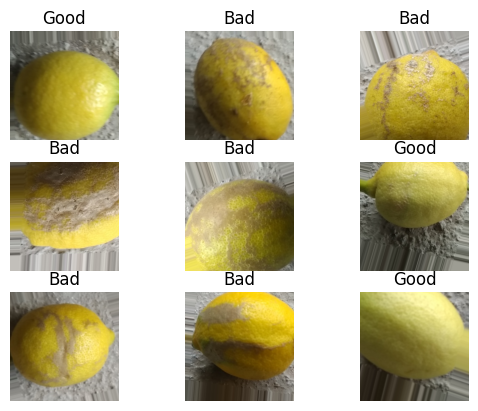

In [ ]:
images = zero_batch_info[0]
labels = zero_batch_info[1]
for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        title = 'Good' if labels[i][0]==0 else 'Bad'
        plt.title(title)
        plt.axis("off")

Zero Shot Model

In [ ]:
num_epochs = 20
learning_rate = 0.001

In [ ]:
def visualize_history(history, epochs=num_epochs):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

In [ ]:
callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
             keras.callbacks.ModelCheckpoint('lemon_zero_shot_{epoch:02d}_{val_accuracy:.3f}.h5',
             save_best_only=True,
             monitor='val_accuracy',
             mode='max')]

Let us try a simple model and assess it's quality.

In [ ]:
zero_model = keras.Sequential([
  keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(300, 300,3)),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(2, activation='softmax')
])


In [ ]:
zero_model.compile(
              optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
zero_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 300, 300, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 150, 150, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 75, 75, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 37, 37, 64)       

In [ ]:
history_zero_model = zero_model.fit(train_ds, epochs=num_epochs,
                                    validation_data=val_ds,
                                    callbacks=callbacks)

Epoch 1/20
52/52 [==============================] - ETA: 0s - loss: 0.6306 - accuracy: 0.7140

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


52/52 [==============================] - 35s 646ms/step - loss: 0.6306 - accuracy: 0.7140 - val_loss: 0.4554 - val_accuracy: 0.8120
Epoch 2/20
52/52 [==============================] - 33s 644ms/step - loss: 0.3225 - accuracy: 0.8778 - val_loss: 0.2005 - val_accuracy: 0.9277
Epoch 3/20
52/52 [==============================] - 34s 662ms/step - loss: 0.1751 - accuracy: 0.9314 - val_loss: 0.1109 - val_accuracy: 0.9566
Epoch 4/20
52/52 [==============================] - 33s 643ms/step - loss: 0.1393 - accuracy: 0.9464 - val_loss: 0.2521 - val_accuracy: 0.9157
Epoch 5/20
52/52 [==============================] - 34s 659ms/step - loss: 0.1401 - accuracy: 0.9470 - val_loss: 0.0560 - val_accuracy: 0.9904
Epoch 6/20
52/52 [==============================] - 35s 664ms/step - loss: 0.0916 - accuracy: 0.9663 - val_loss: 0.0453 - val_accuracy: 0.9831
Epoch 7/20
52/52 [==============================] - 34s 646ms/step - loss: 0.0692 - accuracy: 0.9711 - val_loss: 0.0334 - val_accuracy: 0.9928
Epoch 8/20

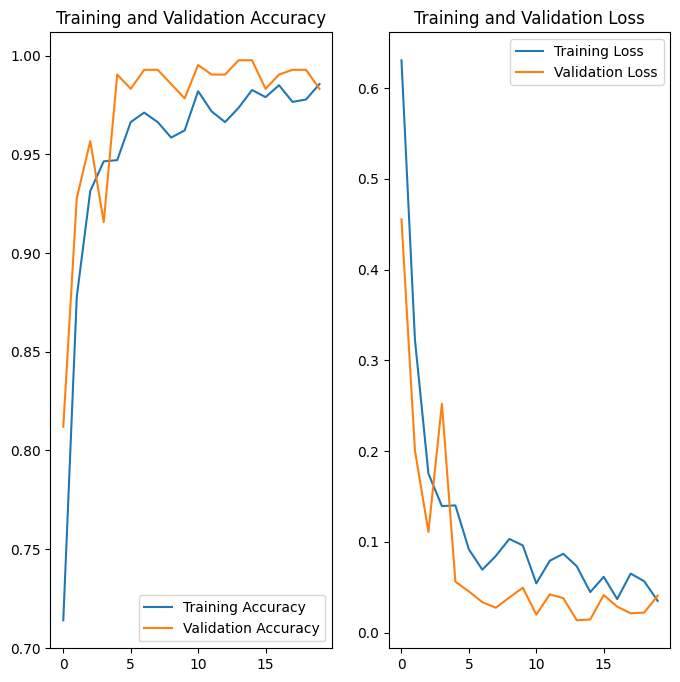

In [ ]:
visualize_history(history_zero_model)

In [ ]:
probability_predictions = zero_model.predict(val_ds)

13/13 [==============================] - 1s 102ms/step


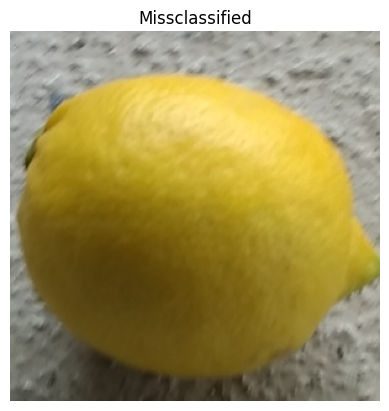

In [ ]:
val_ds_copy = val_ds
k=0
for j, batch in enumerate(val_ds_copy):
    images = batch[0]
    labels = batch[1]
    for im, l in zip(images, labels):
          k=k+1
          if np.argmax(zero_model.predict(im.reshape(1, 300, 300, 3), verbose=0)[0])!=np.argmax(l):
                      plt.imshow(im)
                      plt.title(f'Missclassified')
                      plt.axis("off")

    if j==14:
      break

**Rich augmentation**

Next we try the same model but define a richer image augmentation.

In [ ]:
train_gen_rich = ImageDataGenerator(
    rescale=1.0/255,
    width_shift_range=0.2,
    height_shift_range=0.05,
    vertical_flip=True,
    horizontal_flip=True,
    shear_range=20,
    zoom_range=[0, 1.2],
    rotation_range=30,
)

train_ds_rich = train_gen.flow_from_directory(
    os.path.join(PATH_TO_LEMON_DATASET, 'train'),
    target_size=(300, 300),
    batch_size=32,
)

Found 1661 images belonging to 2 classes.


In [ ]:
rich_augmentation_model = keras.Sequential([
  keras.layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(300, 300,3)),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(128, activation='relu'),
  keras.layers.Dense(2, activation='softmax')
])


In [ ]:
callbacks_rich = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
             keras.callbacks.ModelCheckpoint('lemon_rich_enrichments_{epoch:02d}_{val_accuracy:.3f}.h5',
             save_best_only=True,
             monitor='val_accuracy',
             mode='max')]

In [ ]:
rich_augmentation_model.compile(
              optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
rich_augmentation_model_history= rich_augmentation_model.fit(train_ds_rich, epochs=num_epochs,
                                    validation_data=val_ds,
                                    callbacks=callbacks_rich)

Epoch 1/20
52/52 [==============================] - ETA: 0s - loss: 0.6792 - accuracy: 0.6616 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


52/52 [==============================] - 1001s 19s/step - loss: 0.6792 - accuracy: 0.6616 - val_loss: 0.4063 - val_accuracy: 0.8096
Epoch 2/20
52/52 [==============================] - 38s 733ms/step - loss: 0.3463 - accuracy: 0.8609 - val_loss: 0.2174 - val_accuracy: 0.8964
Epoch 3/20
52/52 [==============================] - 38s 731ms/step - loss: 0.1887 - accuracy: 0.9193 - val_loss: 0.1178 - val_accuracy: 0.9494
Epoch 4/20
52/52 [==============================] - 38s 725ms/step - loss: 0.1376 - accuracy: 0.9446 - val_loss: 0.0588 - val_accuracy: 0.9807
Epoch 5/20
52/52 [==============================] - 38s 721ms/step - loss: 0.1147 - accuracy: 0.9579 - val_loss: 0.0866 - val_accuracy: 0.9639
Epoch 6/20
52/52 [==============================] - 38s 729ms/step - loss: 0.1188 - accuracy: 0.9500 - val_loss: 0.0371 - val_accuracy: 0.9928
Epoch 7/20
52/52 [==============================] - 37s 721ms/step - loss: 0.0690 - accuracy: 0.9741 - val_loss: 0.0294 - val_accuracy: 0.9904
Epoch 8/20

In [ ]:
def visualize_history(history, epochs=num_epochs):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

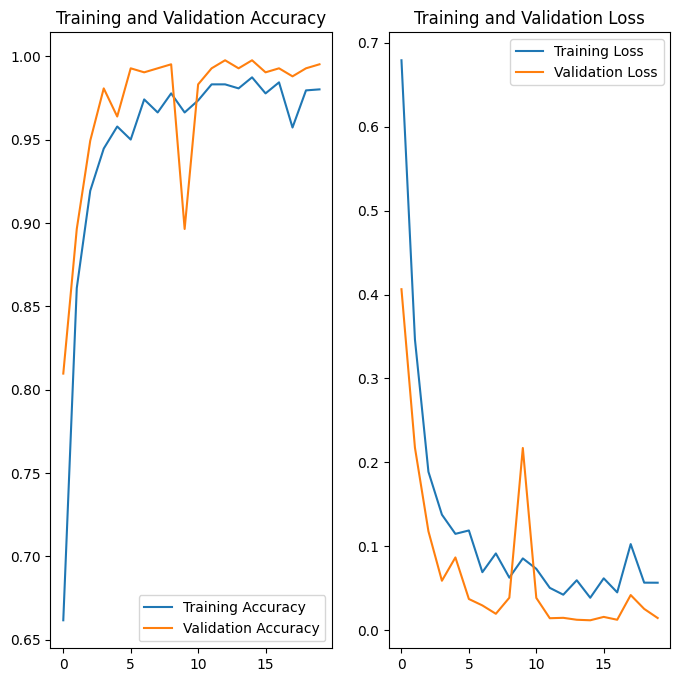

In [ ]:
visualize_history(rich_augmentation_model_history)

**SUMMARY:** Let us take, for instance, the 13 epochs as a final model. It has an almost perfect accuracy and val loss very near to train loss.

**Transfer learning approach using ConvNeXT NN.**

Let us use ConvNeXT NN as a base model for another model. We will omit the last layer and train the final layer on our dataset.

In [ ]:
train_gen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                width_shift_range=0.2,
                                height_shift_range=0.05,
                                vertical_flip=True,
                                rotation_range=20)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
train_ds_convnext_small= train_gen.flow_from_directory(
    os.path.join(PATH_TO_LEMON_DATASET, 'train'),
    target_size=(300, 300),
    batch_size=32,
)

val_ds_convnext_small= val_gen.flow_from_directory(
    os.path.join(PATH_TO_LEMON_DATASET, 'val'),
    target_size=(300, 300),
    batch_size=32,
)

Found 1661 images belonging to 2 classes.
Found 415 images belonging to 2 classes.


In [ ]:
conv_next_small = ConvNeXtSmall(
    include_top=False,
    include_preprocessing=True,
    weights="imagenet",
    input_shape=(300, 300, 3)
)

198551472/198551472 [==============================] - 6s 0us/step


In [ ]:
conv_next_small.trainable=False

In [ ]:
inputs = keras.Input(shape=(300, 300, 3))

base = conv_next_small(inputs, training=False)

vectors = keras.layers.GlobalAveragePooling2D()(base)

outputs = keras.layers.Dense(2, activation='softmax')(vectors)

model_based_on_convnextsmall = keras.Model(inputs, outputs)

In [ ]:
model_based_on_convnextsmall.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 convnext_small (Functional  (None, 9, 9, 768)         49454688  
 )                                                               
                                                                 
 global_average_pooling2d_1  (None, 768)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 2)                 1538      
                                                                 
Total params: 49456226 (188.66 MB)
Trainable params: 1538 (6.01 KB)
Non-trainable params: 49454688 (188.65 MB)
_________________________________________________________________


In [ ]:
callbacks_convnextsmall = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
             keras.callbacks.ModelCheckpoint('lemon_convnextsmall_{epoch:02d}_{val_accuracy:.3f}.h5',
             save_best_only=True,
             monitor='val_accuracy',
             mode='max')]

In [ ]:
model_based_on_convnextsmall.compile(optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
                                     loss=keras.losses.BinaryCrossentropy(),
                                      metrics=['accuracy'])

In [ ]:
model_based_on_convnextsmall_history= model_based_on_convnextsmall.fit(train_ds_convnext_small,
                                                                       epochs=num_epochs,
                                                                      validation_data=val_ds_convnext_small,
                                                                       callbacks=callbacks_convnextsmall)

Epoch 1/20
52/52 [==============================] - ETA: 0s - loss: 0.5770 - accuracy: 0.7086

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


52/52 [==============================] - 51s 976ms/step - loss: 0.5770 - accuracy: 0.7086 - val_loss: 0.4187 - val_accuracy: 0.8120
Epoch 2/20
52/52 [==============================] - 41s 778ms/step - loss: 0.3691 - accuracy: 0.8970 - val_loss: 0.3171 - val_accuracy: 0.8506
Epoch 3/20
52/52 [==============================] - 41s 781ms/step - loss: 0.2867 - accuracy: 0.9380 - val_loss: 0.2709 - val_accuracy: 0.8723
Epoch 4/20
52/52 [==============================] - 41s 782ms/step - loss: 0.2332 - accuracy: 0.9542 - val_loss: 0.2344 - val_accuracy: 0.8916
Epoch 5/20
52/52 [==============================] - 41s 783ms/step - loss: 0.2000 - accuracy: 0.9645 - val_loss: 0.2196 - val_accuracy: 0.8964
Epoch 6/20
52/52 [==============================] - 40s 767ms/step - loss: 0.1796 - accuracy: 0.9657 - val_loss: 0.1924 - val_accuracy: 0.9133
Epoch 7/20
52/52 [==============================] - 40s 762ms/step - loss: 0.1603 - accuracy: 0.9699 - val_loss: 0.1785 - val_accuracy: 0.9157
Epoch 8/20

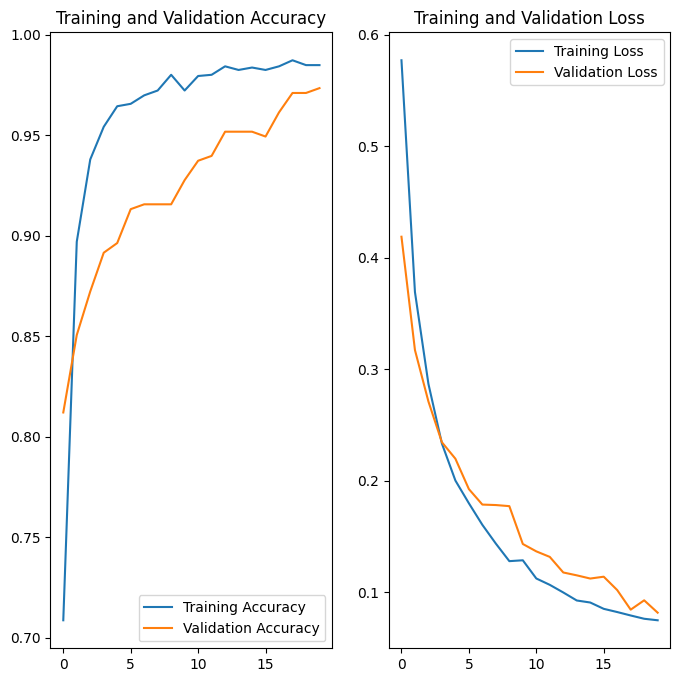

In [ ]:
visualize_history(model_based_on_convnextsmall_history)

The model is pretty good but it does not possess better accuracy/loss. However metrics de(in)crease smoother than for the models before. Moreover this model is larger. To sum it up, we will not use it for the final model.

**Using KerasTuner**

Consider a model defined by model_builder function. We investigate if we can tune kernel_size, number of dense units, learning rate using keras tuner library.

In [ ]:
def model_builder(hp):
  model = keras.Sequential()

  model.add(keras.layers.Input(shape=(300, 300,3)))

  conv_1_kernel_size = hp.Int('kernel_size', min_value=3, max_value=7, step=2)
  dense_units = hp.Int('units', min_value=50, max_value=130, step=10)

  model.add(keras.layers.Conv2D(16, conv_1_kernel_size, activation='relu'))
  model.add(keras.layers.MaxPooling2D())
  model.add(keras.layers.Conv2D(32, conv_1_kernel_size, padding='same', activation='relu'))
  model.add(keras.layers.MaxPooling2D())
  model.add(keras.layers.Conv2D(64, conv_1_kernel_size, padding='same', activation='relu'))
  model.add(keras.layers.MaxPooling2D())
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(dense_units, activation='relu'))
  model.add(keras.layers.Dense(2, activation='softmax'))

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

  return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory=TUNER_DIRECTORY,
                     project_name='lemon_kt')


Reloading Tuner from /drive/MyDrive/tuner/lemon_kt/tuner0.json


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(train_ds, epochs=50, validation_data=val_ds, callbacks=[stop_early])


Trial 26 Complete [00h 05m 31s]
val_accuracy: 0.9879518151283264

Best val_accuracy So Far: 0.9879518151283264
Total elapsed time: 01h 08m 12s


In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')}, kernel size of CNN {best_hps.get('kernel_size')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")



The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 50, kernel size of CNN 3 and the optimal learning rate for the optimizer
is 0.001.



In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model_tuner = tuner.hypermodel.build(best_hps)
history = model_tuner.fit(train_ds, epochs=50, validation_data=val_ds)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))


Epoch 1/50
52/52 [==============================] - 34s 627ms/step - loss: 0.6185 - accuracy: 0.7056 - val_loss: 0.4382 - val_accuracy: 0.8193
Epoch 2/50
52/52 [==============================] - 33s 639ms/step - loss: 0.3923 - accuracy: 0.8278 - val_loss: 0.3047 - val_accuracy: 0.8530
Epoch 3/50
52/52 [==============================] - 34s 656ms/step - loss: 0.3334 - accuracy: 0.8603 - val_loss: 0.2230 - val_accuracy: 0.9133
Epoch 4/50
52/52 [==============================] - 35s 666ms/step - loss: 0.2118 - accuracy: 0.9235 - val_loss: 0.1626 - val_accuracy: 0.9325
Epoch 5/50
52/52 [==============================] - 36s 685ms/step - loss: 0.1598 - accuracy: 0.9446 - val_loss: 0.1458 - val_accuracy: 0.9494
Epoch 6/50
52/52 [==============================] - 34s 656ms/step - loss: 0.1311 - accuracy: 0.9561 - val_loss: 0.0762 - val_accuracy: 0.9831
Epoch 7/50
52/52 [==============================] - 34s 653ms/step - loss: 0.1425 - accuracy: 0.9464 - val_loss: 0.0697 - val_accuracy: 0.9783

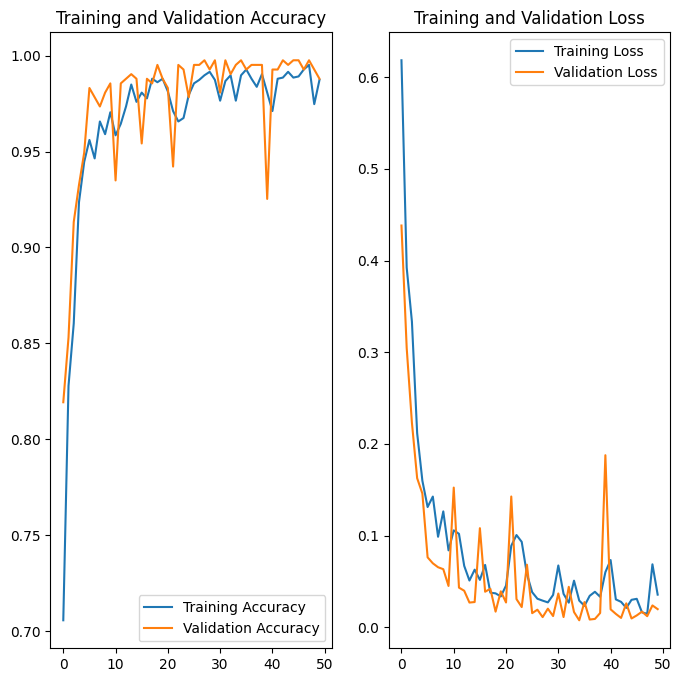

In [ ]:
visualize_history(history, epochs=50)

The results are almost perfect, let us look at the impact of introducing Dropout layer.

In [ ]:
def model_builder_with_dropout(hp):
  model = keras.Sequential()

  model.add(keras.layers.Input(shape=(300, 300,3)))


  dropout_size = hp.Float('rate', min_value=0.1, max_value=0.6, step=0.1)

  model.add(keras.layers.Conv2D(16, 3, activation='relu'))
  model.add(keras.layers.MaxPooling2D())
  model.add(keras.layers.Conv2D(32, 3, padding='same', activation='relu'))
  model.add(keras.layers.MaxPooling2D())
  model.add(keras.layers.Dropout(dropout_size))
  model.add(keras.layers.Conv2D(64, 3, padding='same', activation='relu'))
  model.add(keras.layers.MaxPooling2D())
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(50, activation='relu'))
  model.add(keras.layers.Dropout(dropout_size))
  model.add(keras.layers.Dense(2, activation='softmax'))


  model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])
  return model

In [ ]:
tuner_w_dropout = kt.Hyperband(model_builder_with_dropout,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory=TUNER_DIRECTORY,
                     project_name='lemon_kt')


In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner_w_dropout.search(train_ds, epochs=50, validation_data=val_ds, callbacks=[stop_early])

Trial 5 Complete [00h 01m 09s]
val_accuracy: 0.7927711009979248

Best val_accuracy So Far: 0.9325301051139832
Total elapsed time: 00h 21m 58s


In [ ]:
best_hps=tuner_w_dropout.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal dropout rate is {best_hps.get('rate')}.
""")


The hyperparameter search is complete. The optimal dropout rate is 0.1.



In [ ]:
model_tuner = tuner_w_dropout.hypermodel.build(best_hps)
history = model_tuner.fit(train_ds, epochs=30, validation_data=val_ds)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/30
52/52 [==============================] - 34s 628ms/step - loss: 0.6470 - accuracy: 0.6797 - val_loss: 0.4961 - val_accuracy: 0.7880
Epoch 2/30
52/52 [==============================] - 33s 632ms/step - loss: 0.4668 - accuracy: 0.7863 - val_loss: 0.4039 - val_accuracy: 0.8145
Epoch 3/30
52/52 [==============================] - 33s 634ms/step - loss: 0.3664 - accuracy: 0.8573 - val_loss: 0.3496 - val_accuracy: 0.8072
Epoch 4/30
52/52 [==============================] - 33s 630ms/step - loss: 0.2936 - accuracy: 0.8880 - val_loss: 0.2393 - val_accuracy: 0.9349
Epoch 5/30
52/52 [==============================] - 33s 635ms/step - loss: 0.2924 - accuracy: 0.8910 - val_loss: 0.2086 - val_accuracy: 0.9422
Epoch 6/30
52/52 [==============================] - 33s 632ms/step - loss: 0.2458 - accuracy: 0.9133 - val_loss: 0.1580 - val_accuracy: 0.9398
Epoch 7/30
52/52 [==============================] - 33s 626ms/step - loss: 0.2238 - accuracy: 0.9151 - val_loss: 0.1384 - val_accuracy: 0.9494

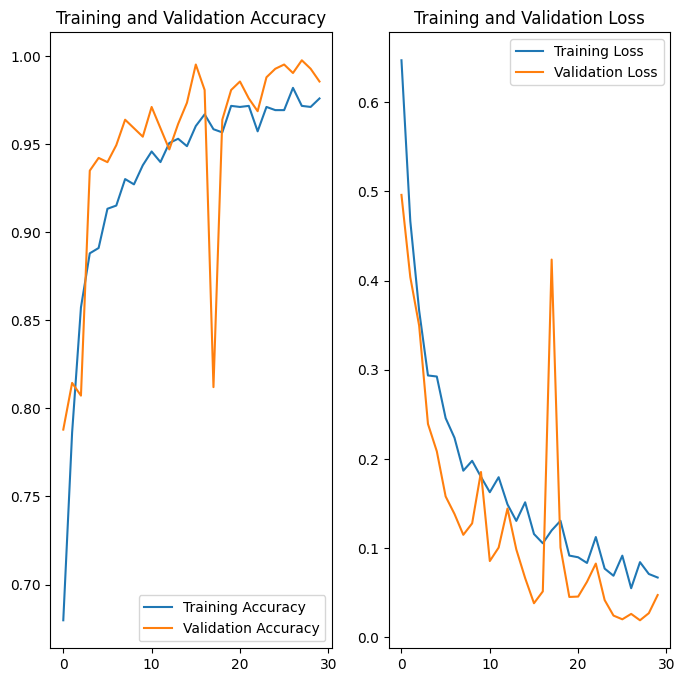

In [ ]:
visualize_history(history, epochs=30)

Clearly dropout did not make the model "better" or more stable. So we avoid using it as the final model.